# Support Vector Regression

In [1]:
import cvxopt as cvx
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial.distance as dt

### Importing Data

In [2]:
data_set = np.genfromtxt("data_set_regression.csv", delimiter = ",")

np.random.seed(421)
train_indices = np.random.choice(range(data_set.shape[0]), size = 100, replace = False)
test_indices = np.setdiff1d(range(data_set.shape[0]), train_indices)
X_train = data_set[train_indices, 0:1]
y_train = data_set[train_indices, 1]
X_test = data_set[test_indices, 0:1]
y_test = data_set[test_indices, 1]
N_train = len(y_train)
D_train = X_train.shape[1]

### Distance and Kernel Functions

$\begin{equation}
    \begin{split}
        d(\boldsymbol{x}_{i}, \boldsymbol{x}_{j}) &= ||\boldsymbol{x}_{i} - \boldsymbol{x}_{j}||_{2} = \sqrt{(\boldsymbol{x}_{i} - \boldsymbol{x}_{j})^{\top} (\boldsymbol{x}_{i} - \boldsymbol{x}_{j})} = \sqrt{\sum\limits_{d = 1}^{D}(x_{id} - x_{jd})^{2}} \\
        k(\boldsymbol{x}_{i}, \boldsymbol{x}_{j}) &= \exp\left(-\dfrac{||\boldsymbol{x}_{i} -\boldsymbol{x}_{j}||_{2}^{2}}{2s^{2}}\right)
    \end{split}
\end{equation}$

In [3]:
def gaussian_kernel(X1, X2, s):
    D = dt.cdist(X1, X2)
    K = np.exp(-D**2 / (2 * s**2))
    return(K)

### Learning Algorithm

#### Primal Problem
$\begin{equation}
	\begin{split}
		\mbox{minimize}\;\;& \dfrac{1}{2} ||\boldsymbol{w}||_{2}^{2} + C \sum\limits_{i = 1}^{N} (\xi_{i}^{+} + \xi_{i}^{-}) \\
		\mbox{with respect to}\;\;& \boldsymbol{w} \in \mathbb{R}^{D},\;\; \boldsymbol{\xi}^{+} \in \mathbb{R}^{N},\;\; \boldsymbol{\xi}^{-} \in \mathbb{R}^{N},\;\; w_{0} \in \mathbb{R} \\
		\mbox{subject to}\;\;& y_{i} - (\boldsymbol{w}^{\top} \boldsymbol{x}_{i} + w_{0}) \leq \epsilon + \xi_{i}^{+} \;\;\;\; i = 1,2,\dots,N \\
		& (\boldsymbol{w}^{\top} \boldsymbol{x}_{i} + w_{0}) - y_{i} \leq \epsilon + \xi_{i}^{-} \;\;\;\; i = 1,2,\dots,N \\
		& \xi_{i}^{+} \geq 0\;\;\;\; i = 1,2,\dots,N \\
    & \xi_{i}^{-} \geq 0\;\;\;\; i = 1,2,\dots,N \\
		\mbox{where}\;\;& C \in \mathbb{R}_{+}
	\end{split}
\end{equation}$

#### Dual Problem
$\begin{equation}
	\begin{split}
		\mbox{maximize}\;\;& \sum\limits_{i = 1}^{N} y_{i} (\alpha_{i}^{+} - \alpha_{i}^{-}) - \epsilon \sum\limits_{i = 1}^{N} (\alpha_{i}^{+} + \alpha_{i}^{-}) - \dfrac{1}{2} \sum\limits_{i = 1}^{N} \sum\limits_{j = 1}^{N} (\alpha_{i}^{+} - \alpha_{i}^{-}) (\alpha_{j}^{+} - \alpha_{j}^{-}) k(\boldsymbol{x}_{i}, \boldsymbol{x}_{j}) \\
		\mbox{with respect to}\;\;& \boldsymbol{\alpha}^{+} \in \mathbb{R}^{N},\;\; \boldsymbol{\alpha}^{-} \in \mathbb{R}^{N} \\
		\mbox{subject to}\;\;& \sum\limits_{i = 1}^{N} (\alpha_{i}^{+} - \alpha_{i}^{-}) = 0 \\
		& 0 \leq \alpha_{i}^{+} \leq C\;\;\;\; i = 1,2,\dots,N \\
    & 0 \leq \alpha_{i}^{-} \leq C\;\;\;\; i = 1,2,\dots,N \\
		\mbox{where}\;\;& C \in \mathbb{R}_{+},\;\;\epsilon \in \mathbb{R}_{+}
	\end{split}
\end{equation}$

#### Dual Problem in Matrix-Vector Form
$\begin{equation}
	\begin{split}
		\mbox{minimize}\;\;&-\boldsymbol{y}^{\top} (\boldsymbol{\alpha}^{+} - \boldsymbol{\alpha}^{-}) + \epsilon \boldsymbol{1}^{\top} (\boldsymbol{\alpha}^{+} + \boldsymbol{\alpha}^{-}) + \dfrac{1}{2} (\boldsymbol{\alpha}^{+} - \boldsymbol{\alpha}^{-})^{\top} \mathbf{K} (\boldsymbol{\alpha}^{+} - \boldsymbol{\alpha}^{-}) \\
		\mbox{with respect to}\;\;& \boldsymbol{\alpha}^{+} \in \mathbb{R}^{N},\;\; \boldsymbol{\alpha}^{-} \in \mathbb{R}^{N} \\
		\mbox{subject to}\;\;& \boldsymbol{1}^{\top} (\boldsymbol{\alpha}^{+} - \boldsymbol{\alpha}^{-}) = 0 \\
		& \boldsymbol{0} \leq \boldsymbol{\alpha}^{+} \leq C \boldsymbol{1} \\
		& \boldsymbol{0} \leq \boldsymbol{\alpha}^{-} \leq C \boldsymbol{1} \\
		\mbox{where}\;\;& C \in \mathbb{R}_{+}
	\end{split}
\end{equation}$

In [4]:
s = 8
K_train = gaussian_kernel(X_train, X_train, s)
C = 1000
tube = 8
epsilon = 1e-3

P = cvx.matrix(np.vstack((np.hstack((+K_train, -K_train)), np.hstack((-K_train, +K_train)))))
q = cvx.matrix(np.append(tube - y_train, tube + y_train)[:,None])
A = cvx.matrix(np.hstack((+1.0 * np.ones((1, N_train)), -1.0 * np.ones((1, N_train)))))
b = cvx.matrix(0.0)
G = cvx.matrix(np.vstack((np.hstack((-np.eye(N_train), np.zeros((N_train, N_train)))),
                          np.hstack((+np.eye(N_train), np.zeros((N_train, N_train)))),
                          np.hstack((np.zeros((N_train, N_train)), -np.eye(N_train))),
                          np.hstack((np.zeros((N_train, N_train)), +np.eye(N_train))))))
h = cvx.matrix(np.vstack((np.zeros((N_train, 1)), C * np.ones((N_train, 1)),
                          np.zeros((N_train, 1)), C * np.ones((N_train, 1)))))

result = cvx.solvers.qp(P, q, G, h, A, b)
alpha = np.reshape(result["x"], 2 * N_train)
alpha[alpha < C * epsilon] = 0
alpha[alpha > C * (1 - epsilon)] = C
alpha = alpha[np.arange(0, N_train)] - alpha[np.arange(N_train, 2 * N_train)]

support_indices, = np.where(alpha != 0)
active_indices, = np.where(np.logical_and(alpha != 0, np.abs(alpha) < C))
w0 = np.mean(y_train[active_indices] - tube * np.sign(alpha[active_indices])) - np.mean(np.matmul(K_train[np.ix_(active_indices, support_indices)], alpha[support_indices]))

     pcost       dcost       gap    pres   dres
 0:  7.1663e+05 -8.3178e+06  9e+06  1e-11  5e-14
 1: -1.4936e+05 -2.0285e+06  2e+06  4e-11  6e-14
 2: -7.3610e+05 -1.2171e+06  5e+05  3e-11  6e-14
 3: -9.0435e+05 -1.0567e+06  2e+05  3e-12  5e-14
 4: -9.4974e+05 -1.0089e+06  6e+04  7e-12  4e-14
 5: -9.7377e+05 -9.8529e+05  1e+04  4e-12  5e-14
 6: -9.7876e+05 -9.7987e+05  1e+03  2e-11  4e-14
 7: -9.7925e+05 -9.7932e+05  7e+01  2e-11  4e-14
 8: -9.7928e+05 -9.7928e+05  4e+00  1e-12  5e-14
 9: -9.7928e+05 -9.7928e+05  8e-02  2e-11  5e-14
Optimal solution found.


### Training Performance

In [5]:
y_predicted = np.matmul(K_train, alpha[:,None]) + w0

rmse_train = np.sqrt(np.mean((y_predicted.flatten() - y_train)**2))
print(rmse_train)

K_test = gaussian_kernel(X_test, X_train, s)
y_predicted = np.matmul(K_test, alpha[:,None]) + w0

rmse_test = np.sqrt(np.mean((y_predicted.flatten() - y_test)**2))
print(rmse_test)

21.481271396016897
24.413755365703842


### Visualization

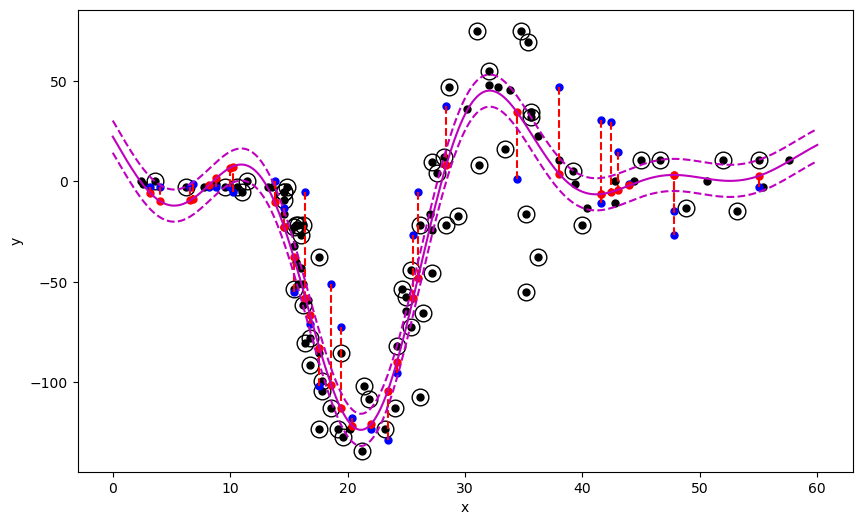

In [6]:
x_interval = np.linspace(0, 60, 601)
X_interval = x_interval[:,None]
K_interval = gaussian_kernel(X_interval, X_train, s)
fitted_values = np.matmul(K_interval, alpha[:,None]) + w0

plt.figure(figsize = (10, 6))
plt.plot(X_train, y_train, "k.", markersize = 10)
plt.plot(X_train[support_indices], y_train[support_indices],
         "ko", markersize = 12, fillstyle = "none")
plt.plot(X_test, y_test, "b.", markersize = 10)
plt.plot(X_test, y_predicted, "r.", markersize = 10)
for i in range(len(y_test)):
    plt.vlines(X_test[i], y_test[i], y_predicted[i], "r", linestyle = "dashed")
plt.plot(X_interval, fitted_values, "m")
plt.plot(X_interval, fitted_values - tube, "m", linestyle = "dashed")
plt.plot(X_interval, fitted_values + tube, "m", linestyle = "dashed")
plt.xlabel("x")
plt.ylabel("y")
plt.show()